In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import re
import os
from fed_distill.cifar10 import prepare_to_visualize
from ipywidgets import interact
from ipywidgets import widgets
%matplotlib inline

In [3]:
NON_ADAPTIVE_STATE = "/mlodata1/jellouli/student_training/non_adaptive2/states/non_adaptive_2_epoch300.tar"
ADAPTIVE_STATE = "/mlodata1/jellouli/student_training/adaptive3/states/adaptive_3_epoch300.tar"
BAD_ADAPTIVE_STATE = "/mlodata1/jellouli/student_training/adaptive2/states/adaptive_2_epoch300.tar"

In [5]:
state_a = torch.load(ADAPTIVE_STATE)
state_n = torch.load(NON_ADAPTIVE_STATE)
state_bad = torch.load(BAD_ADAPTIVE_STATE)

# Bad run: weight decay 10e-3

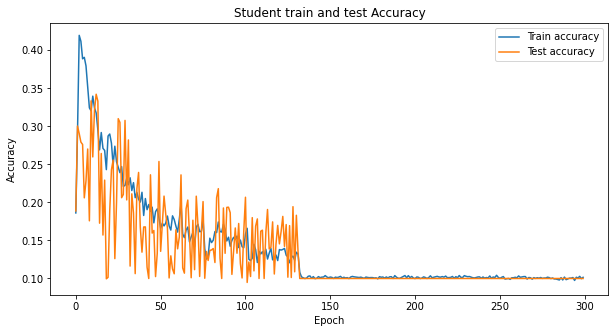

In [6]:
plt.figure(figsize=(10,5))
plt.plot(state_bad['student_train_accs'], label='Train accuracy')
plt.plot(state_bad['student_test_accs'], label='Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Student train and test Accuracy')
plt.legend()
plt.show()

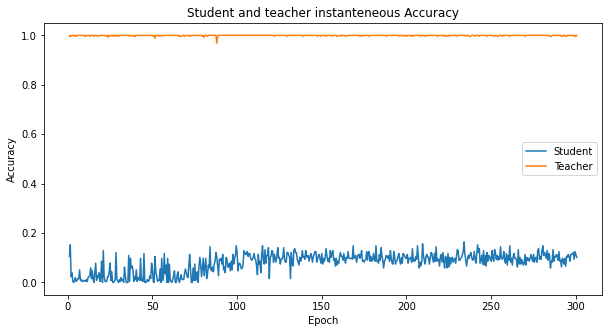

In [7]:
plt.figure(figsize=(10,5))
plt.title('Student and teacher instanteneous Accuracy')
plt.plot(np.arange(1, 301, 0.5), state_bad['student_train_accs_instanteneous'], label='Student')
plt.plot(np.arange(1, 301, 0.5), state_bad['teacher_train_accs_instanteneous'], label='Teacher')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Good run: weight decay (5e-4)

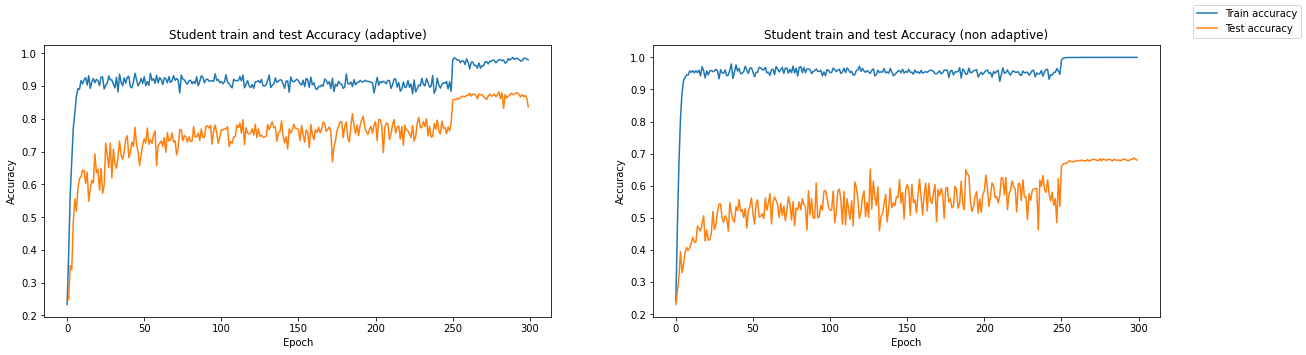

In [8]:
fig, axs = plt.subplots(ncols=2, figsize=(20,5))
axs[0].plot(state_a['student_train_accs'], label='Train accuracy')
axs[0].plot(state_a['student_test_accs'], label='Test accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Student train and test Accuracy (adaptive)')

axs[1].plot(state_n['student_train_accs'])
axs[1].plot(state_n['student_test_accs'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Student train and test Accuracy (non adaptive)')
fig.legend()
fig.show()

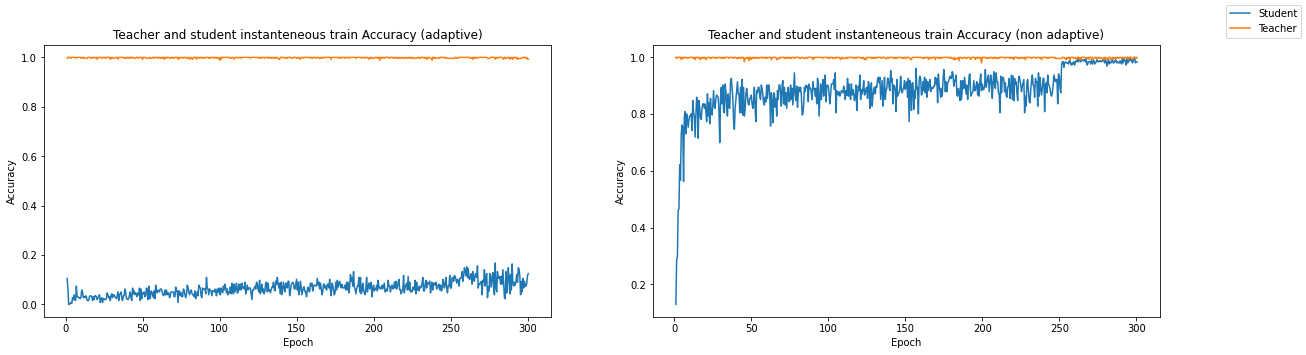

In [19]:
fig, axs = plt.subplots(ncols=2, figsize=(20,5))
axs[0].plot(np.arange(1, 301, 0.5), state_a['student_train_accs_instanteneous'], label='Student')
axs[0].plot(np.arange(1, 301, 0.5), state_a['teacher_train_accs_instanteneous'], label='Teacher')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Teacher and student instanteneous train Accuracy (adaptive)')
axs[1].plot(np.arange(1, 301, 0.5), state_n['student_train_accs_instanteneous'])
axs[1].plot(np.arange(1, 301, 0.5), state_n['teacher_train_accs_instanteneous'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Teacher and student instanteneous train Accuracy (non adaptive)')
fig.legend()
fig.show()

In [10]:
print(f"Accuracy adaptive: {state_a['best_acc']}")
print(f"Accuracy non adaptive: {state_n['best_acc']}")

Accuracy adaptive: 0.8824999928474426
Accuracy non adaptive: 0.6864999532699585


# Images generated

In [11]:
NON_ADAPTIVE_IMAGES = "/mlodata1/jellouli/student_training/non_adaptive2/images"
ADAPTIVE_IMAGES = "/mlodata1/jellouli/student_training/adaptive3/images"

In [12]:
batch_extractor = re.compile(r"(adaptive_3|non_adaptive_2)_batch(?P<batch>[0-9]*).tar")

In [13]:
images_a = {}
images_n = {}

for batch in os.listdir(NON_ADAPTIVE_IMAGES):
    batch_num = int(batch_extractor.fullmatch(batch)['batch'])
    images_n[batch_num] = torch.load(os.path.join(NON_ADAPTIVE_IMAGES, batch))

for batch in os.listdir(ADAPTIVE_IMAGES):
    batch_num = int(batch_extractor.fullmatch(batch)['batch'])
    images_a[batch_num] = torch.load(os.path.join(ADAPTIVE_IMAGES, batch))

In [14]:
from fed_distill.cifar10.cifar10_helpers import class_to_name
name_to_class = dict((v, k) for (k,v) in class_to_name.items())

In [17]:
def get_images_for_class(images,labels, num_images, label):
    class_images = images[np.argwhere(labels.cpu().numpy() == label).reshape(-1)]
    # sample = np.random.choice(range(len(class_images)), size=num_images, replace=False)
    if num_images > 1:
        return class_images[:num_images].squeeze(0)
    else:
        return class_images[:num_images]

def viz_images_for_batch(batch_num, label):
    label = name_to_class[label]
    num_images = 5
    fig, axs = plt.subplots(ncols=num_images, nrows=2, squeeze=False, sharey=True, figsize=(20,5))
    image_a = get_images_for_class(images_a[batch_num]['images'], images_a[batch_num]['labels'], num_images, label)
    image_n = get_images_for_class(images_n[batch_num]['images'], images_n[batch_num]['labels'], num_images, label)
    for i in range(num_images):
        axs[0, i].imshow(prepare_to_visualize(image_a[i]))
    for i in range(num_images):
        axs[1, i].imshow(prepare_to_visualize(image_n[i]))
    fig.show()

In [18]:
interact(viz_images_for_batch, batch_num=widgets.IntSlider(min=1, max=600, step=1, value=1), label=name_to_class.keys())
plt.show()

interactive(children=(IntSlider(value=1, description='batch_num', max=600, min=1), Dropdown(description='label…